### Training Neural Network on MNIST dataset Using Numpy 

In [1]:
from collections import namedtuple
from collections import deque
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
_ = plt.gray();

### Load dataset

In [2]:
class MNIST(object):
    image = namedtuple("image", "data,normalized_data,w,h,size")
    label = namedtuple("label", "label,encoded,size")
    
    def __init__(self):
        self.train_image = self.read_image("train-images-idx3-ubyte")
        self.test_image = self.read_image("t10k-images-idx3-ubyte")
        self.train_label = self.read_label("train-labels-idx1-ubyte")
        self.test_label = self.read_label("t10k-labels-idx1-ubyte")
    
    def as_int(self, bytes):
        r = 0
        for b in bytes:
            r = (r << 8) | ord(b)
        return r
    
    def read_label(self, filename):
        with open(filename, "rb") as f:
            self.as_int(f.read(4)) # magic number
            size = self.as_int(f.read(4))
            digits = np.array(map(lambda x: ord(x), f.read(-1)))
            encoded = np.zeros([size, 10], dtype=np.float64)
            encoded[np.arange(size),digits] = 1
        return self.label(digits, encoded, size)
    
    def read_image(self, filename):
        with open(filename, "rb") as f:
            self.as_int(f.read(4)) # magic number
            size = self.as_int(f.read(4))
            w = self.as_int(f.read(4))
            h = self.as_int(f.read(4))
            data = np.array(map(lambda x: ord(x), f.read(-1)), dtype=np.float64).reshape(-1, w*h)
            norm = (data - data.mean(axis=0)) / (data.std(axis=0) + 1e-5)
        return self.image(data=data, normalized_data=norm, w=w, h=h, size=size)
    
    def _range_max(self, row, length):
        queue = deque()
        output = [0 for _ in xrange(len(row) - length + 1)]
        length -= 1
        for j, e in enumerate(row):
            while(len(queue) != 0 and queue[0][0] <= e):
                queue.popleft()
            queue.appendleft((e, j))
            if j < length:
                continue
            while(queue[-1][1] < (j - length)):
                queue.pop()
            
            output[j - length] = queue[-1][0]
            
        return output
        
    def _grid_max(self, arr2d, grid=(4, 4)):
        temp = np.array([self._range_max(arr1d, length=grid[0]) for arr1d in arr2d]).T
        return np.array([self._range_max(arr1d, length=grid[1]) for arr1d in temp]).T
    
    def augment_feature(self, data, grid=(5, 5)):
        """
        data is a 784xS size 2d array
        each row is reshaped 28x28 image
        lets calculate max in each grid
        """
        imsize = 28
        data_cube = data.reshape(data.shape[0], imsize, imsize)
        return np.array([self._grid_max(matrix, grid) for matrix in data_cube])

mnist = MNIST()

### Visualize Some Sample from Dataset

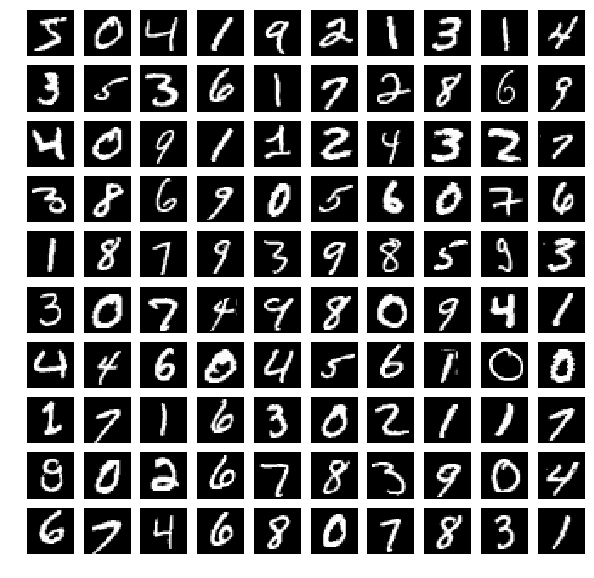

In [3]:
# visualize raw data
fig = plt.figure(figsize=(10, 10))
plt.gray()
for i in range(100):
    fig.add_subplot(10, 10, i + 1).axis("off")
    plt.imshow(mnist.train_image.data[i,:].reshape(28,28), figure=fig)

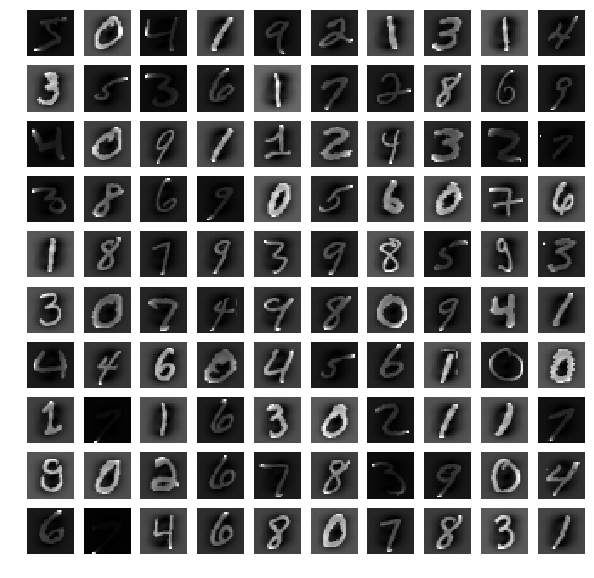

In [4]:
fig = plt.figure(figsize=(10,10))
for i in range(100):
    fig.add_subplot(10, 10, i + 1).axis("off")
    plt.imshow(mnist.train_image.normalized_data[i,:].reshape(28,28), figure=fig)

### Bulding Model

In [421]:
"""
define functions
"""
class Sigmoid(object):
    def __init__(self):
        self.f = self._f
        self.df = self._df
    
    def _f(self, w):
        w_ = w.copy()
        w_[w < -500] = -500.0
        return 1.0 / (1 + np.exp(-w_))
    
    def _df(self, w):
        w_ = self._f(w)
        return w_ * (1 - w_)
    
class PReLU(object):
    def __init__(self, a=0.001, c=2.0, b=0.001):
        self.a = a
        self.c = c
        self.b = b
        self.f = self._f
        self.df = self._df
    
    def _f(self, w):
        w_ = np.min([w, self.c + w * self.b], axis=0)
        return np.max([self.a * w, w_], axis=0)
    
    def _df(self, w):
        w_ = np.zeros(shape=w.shape) + 1.0
        w_[w < 0] = self.a
        w_[w > self.c] = self.b
        return w_

class LogisticLossFn(object):
    def __init__(self, f):
        self.f_ = f
        if isinstance(f, Sigmoid):
            self.f = self._sf
            self.df = self._sdf
        else:
            self.f = np.vectorize(self._f)
            self.df = np.vectorize(self._df)

    def _sf(self, x, y):
        x_ = x.copy()
        x_[x < -500] = -500
        return np.log(1 + np.exp(-x)) + x * (1.0 - y)
    
    def _sdf(self, x, y):
        return (self.f_.f(x) - y)
        
    def _f(self, x, y):
        y_ = self.f_.f(x)
        return -(y * np.log(y_) + (1 - y) * np.log(1 - y_))
    
    def _df(self, x, y):
        y_ = self.f_.f(x)
        df = self.f_.df(x)
        return (1 - y) * df / (1 - y_) - y * df / y_
    
class CatCrossEntLossFn(object):
    def __init__(self, **kwargs):
        pass
        
    def f(self, x, y_=None):
        x_ = np.exp(x - np.max(x, axis=1).reshape(-1, 1))
        x_ = x_ / np.sum(x_, axis=1).reshape(-1, 1)
        return x_ if y_ is None else x_ * y_
    
    def df(self, x, y_=None):
        if y_ is not None:
            return -(1.0 - self.f(x)) * y_
        return -(1.0 - self.f(x))

class SquareLossFn(object):
    def __init__(self, f):
        self.f_ = f
        self.f = np.vectorize(self._f)
        self.df = np.vectorize(self._df)

    def _f(self, x, y):
        d = self.f_.f(x) - y
        return d * d
    
    def _df(self, x, y):
        y_ = self.f_.f(x)
        df = self.f_.df(x)
        return (y_ - y) * df
    
class Layer(object):
    """
    Layer object
    """
    def __init__(self, func=Sigmoid(), in_shape=None, out_shape=None):
        self.in_shape = in_shape
        self.out_shape = out_shape
        self.func = func
    
    def init(self):
        alpha = np.sqrt(6.0 / (self.in_shape + self.out_shape))
        self.w = alpha * np.random.uniform(low=-1, high=1, size=[self.in_shape, self.out_shape])
        self.b_ = np.zeros(shape=[1, self.out_shape])
        
    @property
    def W(self):
        return self.w
    
    @property
    def Y(self):
        return self.y
    
    @property
    def Y_(self):
        return self.y_
    
    @property
    def b(self):
        return self.b_
    
    def forward_prop(self, X):
        self.wx_ = np.matmul(X, self.w) + self.b_
        self.X_out = self.func.f(self.wx_)
        return self.X_out
    
    def backward_prop(self, delta, alpha=1.0):
        df = self.func.df(self.wx_) * delta
        delta = np.matmul(df, self.w.T)
        self.w = self.w - np.matmul(self.X_out.T, df)
        self.b_ = self.b_ -  np.sum(df, axis=0)
        return delta

def accuracy(y_, X_):
    y_ = np.argmax(y_, axis=1)
    X_ = np.argmax(X_, axis=1)
    return 1.0 * np.sum(y_ == X_) / X_.shape[0]

In [427]:
# define neural network
class Network(object):
    """
    A simple Neural Network implementation
    """
    def __init__(self):
        self.layers = []
        self.alpha = 0.1
    
    def append(self, layer):
        """
        add a new layer to network
        """
        if not isinstance(layer, Layer):
            raise TypeError("Layer should be instance of Layer")
        if layer.in_shape == None:
            if len(self.layers) == 0:
                raise ValueError("Missing input shape")
            else:
                layer.in_shape = self.layers[-1].out_shape
        self.layers.append(layer)
        return self
                
    def init(self):
        """
        initialize before training
        """
        for layer in self.layers:
            layer.init()
        
        if isinstance(self.layers[-1].func, Sigmoid):
            self.loss_fn = LogisticLossFn(f=self.layers[-1].func)
        else:
            self.loss_fn = SquareLossFn(f=self.layers[-1].func)

    def train(self, X, y, batch_size=100, max_iter=10, metrics=accuracy, reg=0.0):
        """
        Train model with SGD on batches
        """
        self.init()
        size = len(self.layers)
        norm = 1.0 / batch_size
        alpha = self.alpha
        
        perm = np.random.permutation(X.shape[0])
        X, y = X[perm, :], y[perm, :]
        train_size = int(0.7 * X.shape[0])
        X_train, X_test = X[:train_size, :], X[train_size:, :]
        y_train, y_test = y[:train_size, :], y[train_size:, :]
        
        for _ in range(max_iter):
            perm = np.random.permutation(X_train.shape[0])
            for batch in range(0, X_train.shape[0], batch_size):
                if batch + batch_size >= X.shape[0]:
                    break
                select = perm[batch:batch + batch_size]
                X_, y_ = X_train[select, :], y_train[select, :]
            
                wx = list()
                xx = list()
                
                for layer in self.layers:
                    xx.append(X_)
                    wx.append(np.matmul(X_,  layer.w) + layer.b)
                    X_ = layer.func.f(wx[-1])

                layer = self.layers[-1]
                df = delta = self.loss_fn.df(wx[-1], y_)
                
                delta = alpha * np.matmul(df, layer.w.T) * norm
                layer.w = layer.w - alpha * (np.matmul(xx[-1].T, df) * norm)
                layer.b_ = layer.b_ - alpha * np.sum(df, axis=0) * norm

                for i in range(size - 2, -1, -1):
                    layer = self.layers[i]
                    wx_, x_ = wx[i], xx[i]
                    df = layer.func.df(wx_) * delta
                    delta = np.matmul(df, layer.w.T)
                    layer.w = layer.w - (np.matmul(x_.T, df))
                    layer.b_ = layer.b_ -  np.sum(df, axis=0)
                
            X_ = self.predict_(X_test)
            loss = np.sum(self.loss_fn.f(X_, y_test)) / X_test.shape[0]
            accuracy = metrics(X_, y_test)
            lrd = 1 - pow(accuracy, 9) + 1e-7
            alpha = alpha * lrd
            print "Epoch finished, loss: %0.3f, accuracy: %0.3f" % (loss, accuracy)
            
        return self
    
    def predict_(self, X):
        X_ = X.copy()
        for layer in self.layers:
            X_ = layer.func.f(np.matmul(X_, layer.w) + layer.b)
        return X_
    
    def predict(self, X):
        X_ = self.predict_(X)
        X_[np.arange(X.shape[0]), np.argmax(X_, axis=1)] = 1
        return X_

### Train a single layer neural network

In [428]:
d_in, d_out = 784, 10
network1 = Network()\
    .append(Layer(func=Sigmoid(), in_shape=d_in, out_shape=d_out))

network1.train(mnist.train_image.normalized_data, mnist.train_label.encoded, batch_size=64, max_iter=10)

result = network1.predict(mnist.test_image.normalized_data)
accuracy(result, mnist.test_label.encoded)

Epoch finished, loss: 6.831, accuracy: 0.887
Epoch finished, loss: 6.786, accuracy: 0.897
Epoch finished, loss: 6.771, accuracy: 0.897
Epoch finished, loss: 6.763, accuracy: 0.902
Epoch finished, loss: 6.760, accuracy: 0.903
Epoch finished, loss: 6.759, accuracy: 0.903
Epoch finished, loss: 6.758, accuracy: 0.903
Epoch finished, loss: 6.757, accuracy: 0.903
Epoch finished, loss: 6.757, accuracy: 0.903
Epoch finished, loss: 6.757, accuracy: 0.903


0.9092

### Lets visualize weights

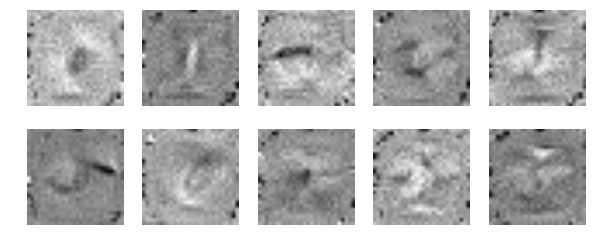

In [429]:
weight = network1.layers[0].w.copy()
fig = plt.figure(figsize=(10, 4))
for i in range(10):
    fig.add_subplot(2, 5, i + 1).axis("off")
    plt.imshow(weight[:, i].reshape(28,28), figure=fig, interpolation='bilinear')

### Train a multi-layer neural network (Input->PRelu->Sigmoid->Output)

In [431]:
d_in, d_out = 784, 10
network2 = Network()\
    .append(Layer(func=PReLU(a=0.0001, c=5.0, b=0.001), in_shape=d_in, out_shape=400))\
    .append(Layer(func=PReLU(a=0.0001, c=5.0, b=0.001), out_shape=64))\
    .append(Layer(func=Sigmoid(), out_shape=d_out))
network2.train(mnist.train_image.normalized_data, mnist.train_label.encoded, batch_size=100, max_iter=10)

result1 = network2.predict(mnist.test_image.normalized_data)
accuracy(result1, mnist.test_label.encoded)

Epoch finished, loss: 6.631, accuracy: 0.951
Epoch finished, loss: 6.618, accuracy: 0.958
Epoch finished, loss: 6.615, accuracy: 0.959
Epoch finished, loss: 6.614, accuracy: 0.960
Epoch finished, loss: 6.614, accuracy: 0.960
Epoch finished, loss: 6.614, accuracy: 0.960
Epoch finished, loss: 6.614, accuracy: 0.960
Epoch finished, loss: 6.614, accuracy: 0.960
Epoch finished, loss: 6.614, accuracy: 0.960
Epoch finished, loss: 6.614, accuracy: 0.960


0.961

### Instances where Neural Network failed

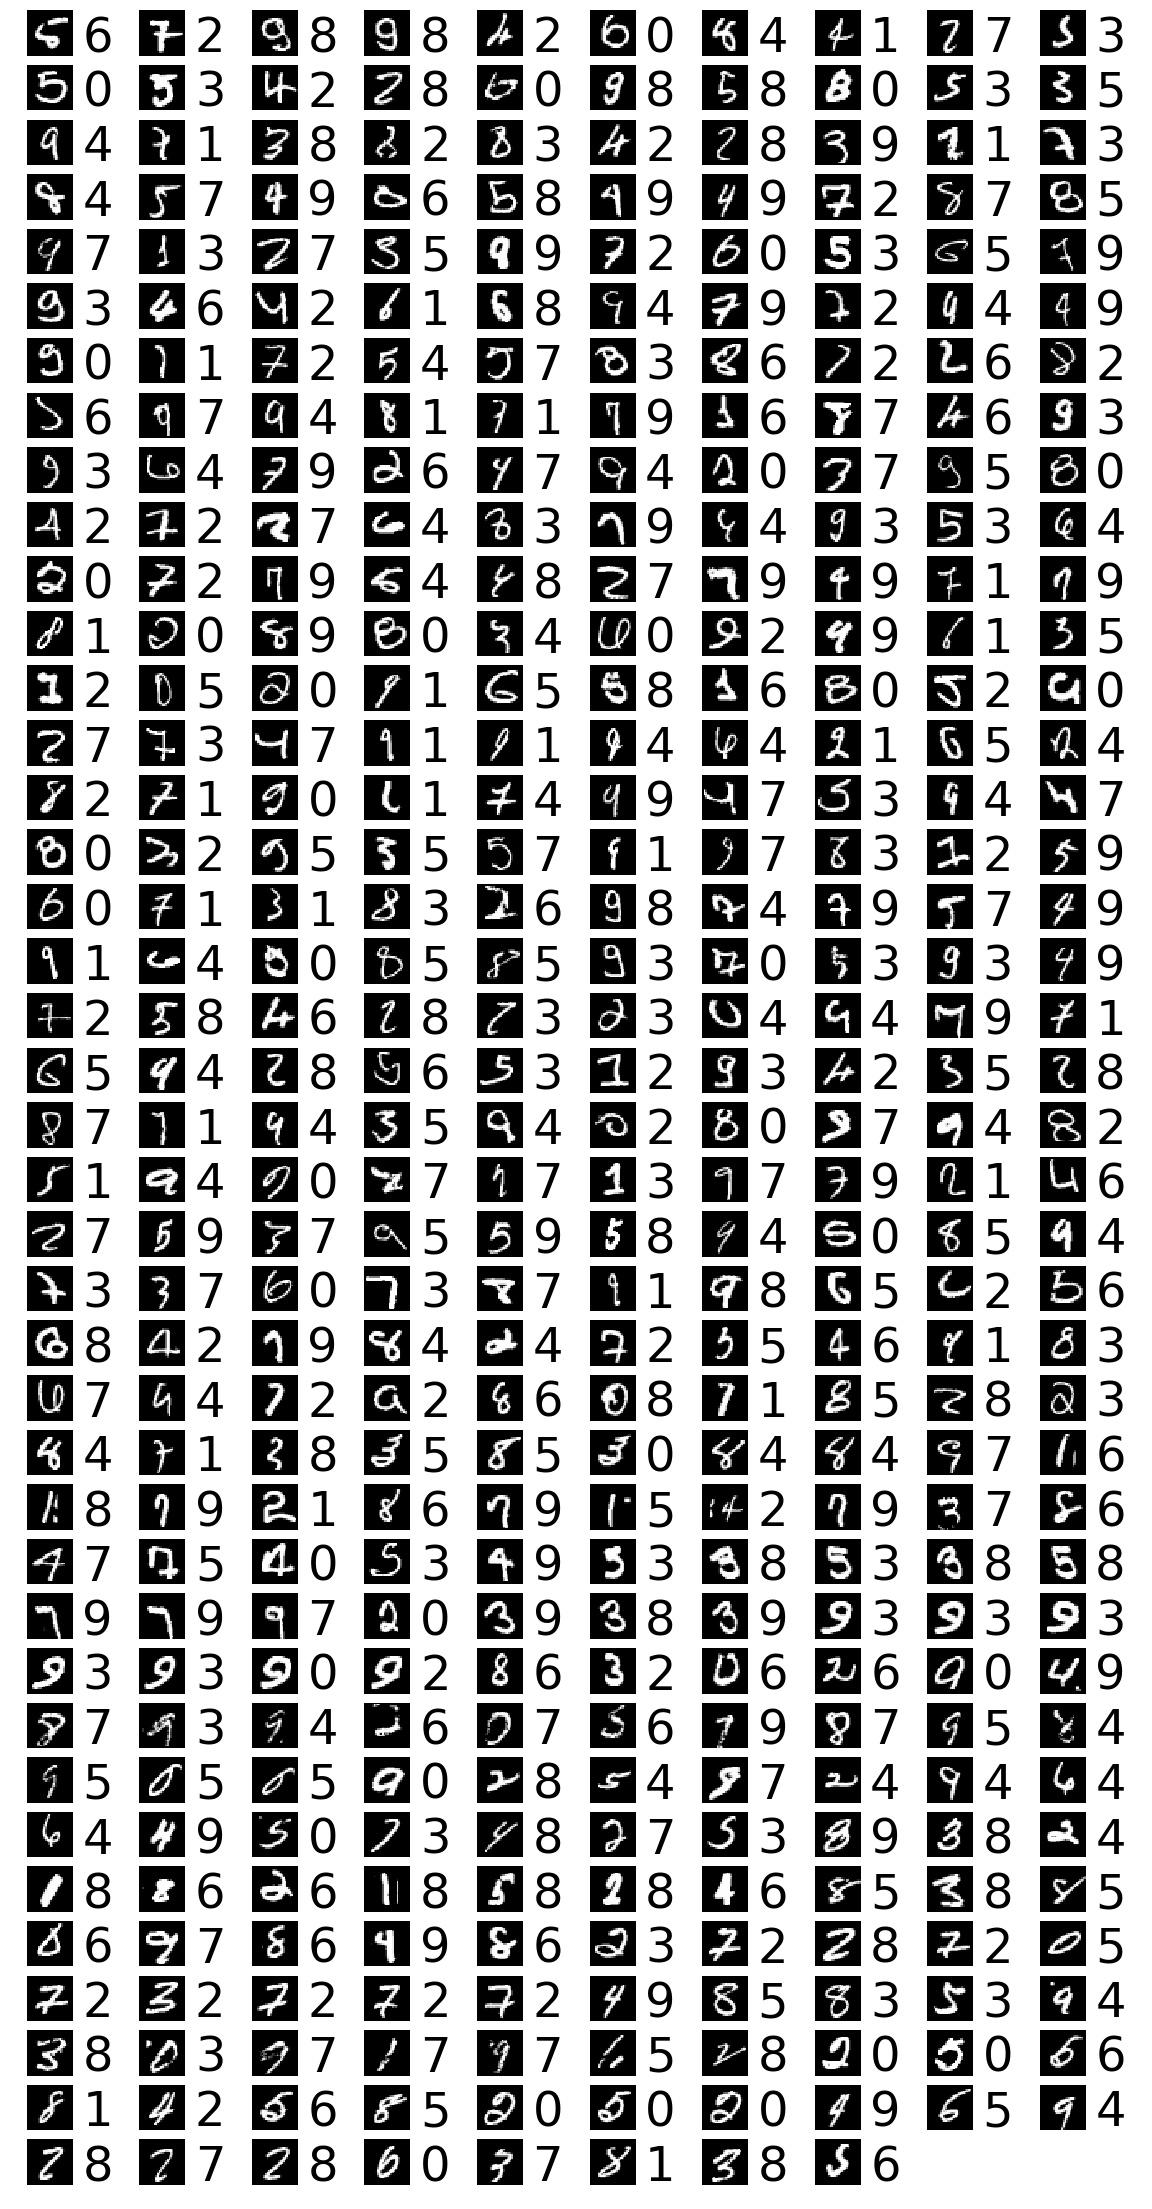

In [349]:
prediction = np.argmax(result1, axis=1)
indices = mnist.test_label.label != prediction
error_images = mnist.test_image.data[indices, :]
pred = prediction[indices]
fig = plt.figure(figsize=(20, 40))
for i in range(error_images.shape[0]):
    fig.add_subplot(40, 20, 2*i + 1).axis("off")
    plt.imshow(error_images[i,:].reshape(28,28), figure=fig)
    fig.add_subplot(40, 20, 2*i + 2).axis("off")
    plt.text(0.0, 0.1, str(pred[i]), fontsize=48)

### Lets visualize weights of first layer

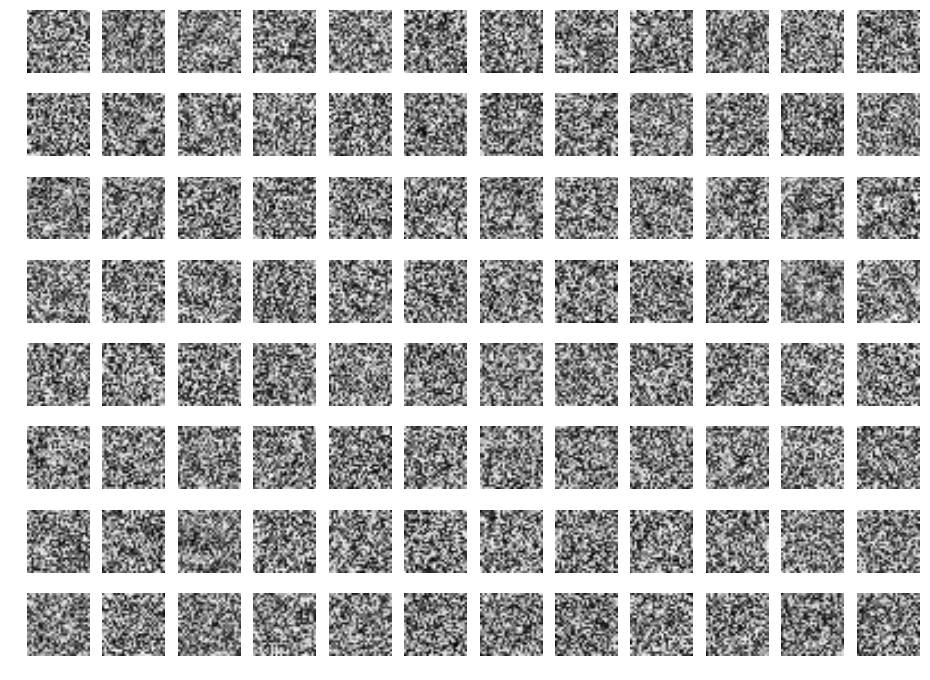

In [391]:
weight = network2.layers[0].w.copy()
fig = plt.figure(figsize=(16,12))
plt.gray()
for i in range(96):
    fig.add_subplot(8, 12, i + 1).axis("off")
    plt.imshow(weight[:, i].reshape(28,28), figure=fig, interpolation='bilinear')

### Visualization of Weight of Second Layer

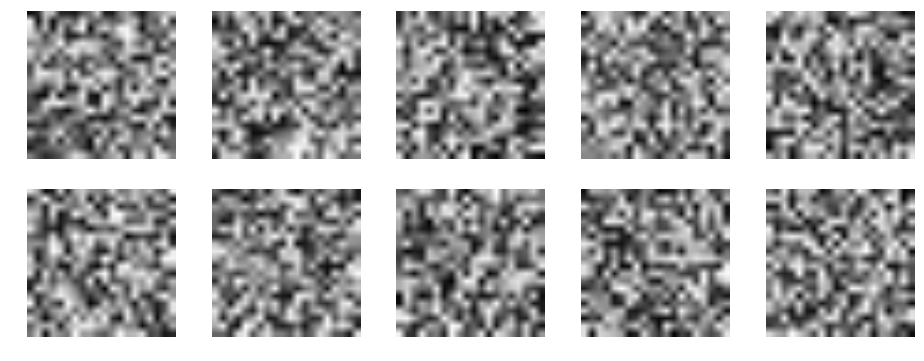

In [392]:
weight = network2.layers[1].w.copy()
fig = plt.figure(figsize=(16,6))
for i in range(10):
    fig.add_subplot(2, 5, i + 1).axis("off")
    plt.imshow(weight[:, i].reshape(20, 20), figure=fig, interpolation="bilinear")

### Output from The First Layer

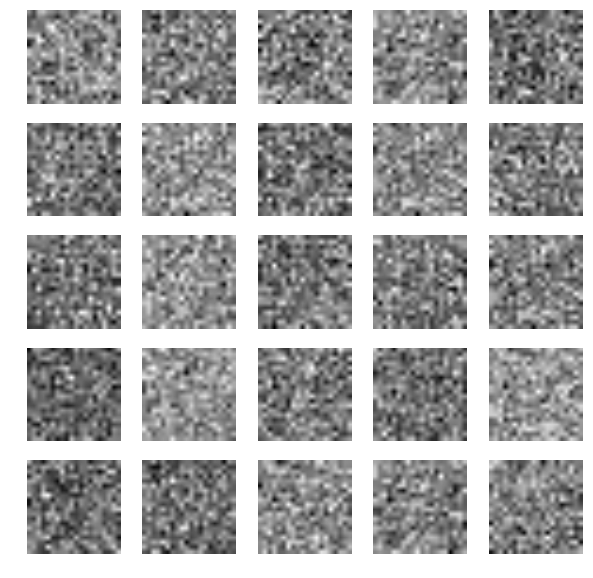

In [119]:
result = np.matmul(mnist.train_image.normalized_data[0:25,:], network2.layers[0].w) + network2.layers[0].b
fig = plt.figure(figsize=(10,10))
for i in range(25):
    fig.add_subplot(5, 5, i + 1).axis("off")
    plt.imshow(result[i,:].reshape(20, 20), figure=fig, interpolation="bilinear")

### Training with augmented data

In [477]:
grid = (3, 3)
augmented_train = mnist.augment_feature(mnist.train_image.data, grid=grid)
augmented_test = mnist.augment_feature(mnist.test_image.data, grid=grid)

In [480]:
augmented_train_norm = (augmented_train - augmented_train.mean(axis=0)) / (augmented_train.std() + 1e-10)
augmented_test_norm = (augmented_test - augmented_train.mean(axis=0)) / (augmented_test.std() + 1e-10)

In [484]:
size = augmented_train_norm.shape[1] * augmented_train_norm.shape[2]
all_feature_train = np.concatenate([mnist.train_image.normalized_data, augmented_train_norm.reshape(-1, size)], axis=1)
all_feature_test = np.concatenate([mnist.test_image.normalized_data, augmented_test_norm.reshape(-1, size)], axis=1)

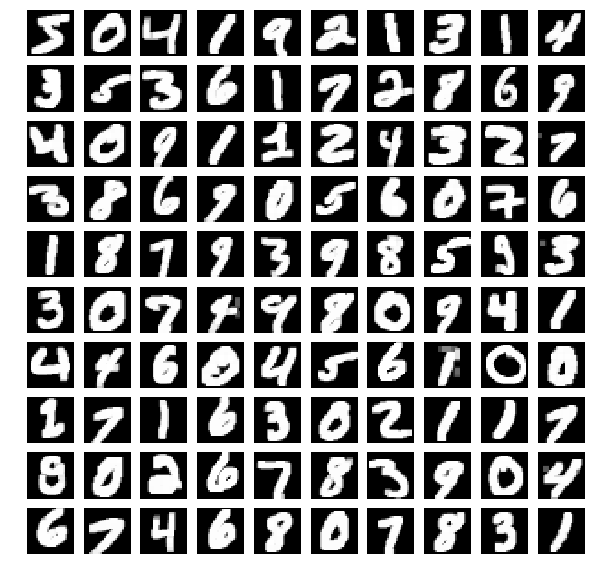

In [479]:
fig = plt.figure(figsize=(10, 10))
for i in range(100):
    fig.add_subplot(10, 10, i + 1).axis("off")
    plt.imshow(augmented_train[i,:].reshape(26,26), figure=fig)

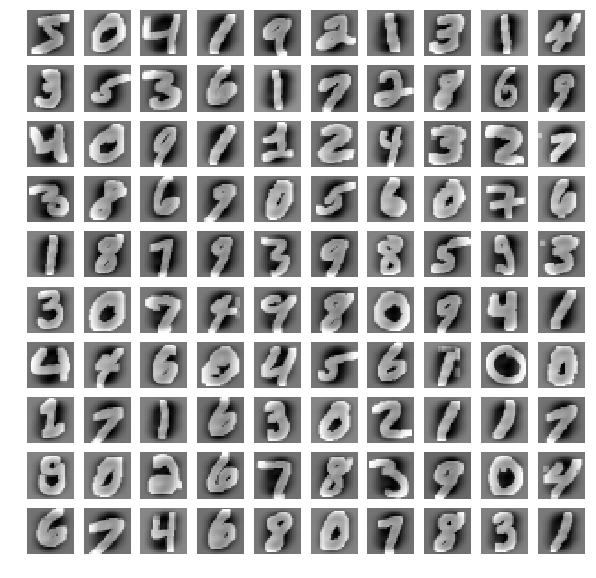

In [485]:
fig = plt.figure(figsize=(10, 10))
for i in range(100):
    fig.add_subplot(10, 10, i + 1).axis("off")
    plt.imshow(augmented_train_norm[i,:].reshape(26,26), figure=fig)

In [488]:
d_in, d_out = 676, 10
network3 = Network()\
    .append(Layer(func=Sigmoid(), in_shape=d_in, out_shape=d_out))

network3.train(augmented_train_norm.reshape(-1, size), mnist.train_label.encoded, batch_size=64, max_iter=10)

result3 = network3.predict(augmented_test_norm.reshape(-1, size))
accuracy(result3, mnist.test_label.encoded)

Epoch finished, loss: 6.818, accuracy: 0.888
Epoch finished, loss: 6.774, accuracy: 0.897
Epoch finished, loss: 6.761, accuracy: 0.899
Epoch finished, loss: 6.753, accuracy: 0.902
Epoch finished, loss: 6.751, accuracy: 0.903
Epoch finished, loss: 6.749, accuracy: 0.904
Epoch finished, loss: 6.748, accuracy: 0.904
Epoch finished, loss: 6.747, accuracy: 0.904
Epoch finished, loss: 6.747, accuracy: 0.904
Epoch finished, loss: 6.747, accuracy: 0.904


0.9136

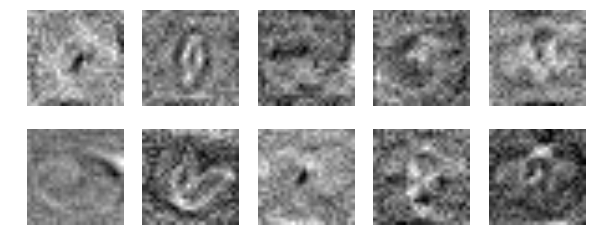

In [495]:
weight = network3.layers[0].w.copy()
fig = plt.figure(figsize=(10, 4))
for i in range(10):
    fig.add_subplot(2, 5, i + 1).axis("off")
    plt.imshow(weight[:, i].reshape(26,26), figure=fig, interpolation='bilinear')

In [489]:
d_in, d_out = all_feature_train.shape[1], 10
network4 = Network()\
    .append(Layer(func=Sigmoid(), in_shape=d_in, out_shape=d_out))

network4.train(all_feature_train, mnist.train_label.encoded, batch_size=64, max_iter=10)

result4 = network4.predict(all_feature_test)
accuracy(result4, mnist.test_label.encoded)

Epoch finished, loss: 6.784, accuracy: 0.911
Epoch finished, loss: 6.742, accuracy: 0.922
Epoch finished, loss: 6.728, accuracy: 0.927
Epoch finished, loss: 6.724, accuracy: 0.929
Epoch finished, loss: 6.722, accuracy: 0.929
Epoch finished, loss: 6.720, accuracy: 0.930
Epoch finished, loss: 6.720, accuracy: 0.929
Epoch finished, loss: 6.720, accuracy: 0.929
Epoch finished, loss: 6.720, accuracy: 0.929
Epoch finished, loss: 6.720, accuracy: 0.929


0.9339

In [490]:
d_in, d_out = 676, 10

network5 = Network()\
    .append(Layer(func=PReLU(a=0.0001, c=5.0, b=0.001), in_shape=d_in, out_shape=400))\
    .append(Layer(func=PReLU(a=0.0001, c=5.0, b=0.001), out_shape=64))\
    .append(Layer(func=Sigmoid(), out_shape=d_out))
network5.train(augmented_train_norm.reshape(-1, size), mnist.train_label.encoded, batch_size=64, max_iter=10)

result5 = network5.predict(augmented_test_norm.reshape(-1, size))
accuracy(result5, mnist.test_label.encoded)

Epoch finished, loss: 6.619, accuracy: 0.955
Epoch finished, loss: 6.608, accuracy: 0.963
Epoch finished, loss: 6.603, accuracy: 0.967
Epoch finished, loss: 6.603, accuracy: 0.967
Epoch finished, loss: 6.602, accuracy: 0.967
Epoch finished, loss: 6.602, accuracy: 0.967
Epoch finished, loss: 6.602, accuracy: 0.967
Epoch finished, loss: 6.602, accuracy: 0.967
Epoch finished, loss: 6.602, accuracy: 0.967
Epoch finished, loss: 6.602, accuracy: 0.967


0.9693

In [491]:
d_in, d_out = all_feature_train.shape[1], 10

network6 = Network()\
    .append(Layer(func=PReLU(a=0.0001, c=5.0, b=0.001), in_shape=d_in, out_shape=400))\
    .append(Layer(func=PReLU(a=0.0001, c=5.0, b=0.001), out_shape=64))\
    .append(Layer(func=Sigmoid(), out_shape=d_out))
    
network6.train(all_feature_train, mnist.train_label.encoded, batch_size=64, max_iter=10)

result6 = network6.predict(all_feature_test)
accuracy(result6, mnist.test_label.encoded)

Epoch finished, loss: 6.613, accuracy: 0.961
Epoch finished, loss: 6.599, accuracy: 0.967
Epoch finished, loss: 6.595, accuracy: 0.969
Epoch finished, loss: 6.595, accuracy: 0.969
Epoch finished, loss: 6.595, accuracy: 0.970
Epoch finished, loss: 6.595, accuracy: 0.970
Epoch finished, loss: 6.595, accuracy: 0.970
Epoch finished, loss: 6.595, accuracy: 0.970
Epoch finished, loss: 6.595, accuracy: 0.970
Epoch finished, loss: 6.595, accuracy: 0.970


0.9719

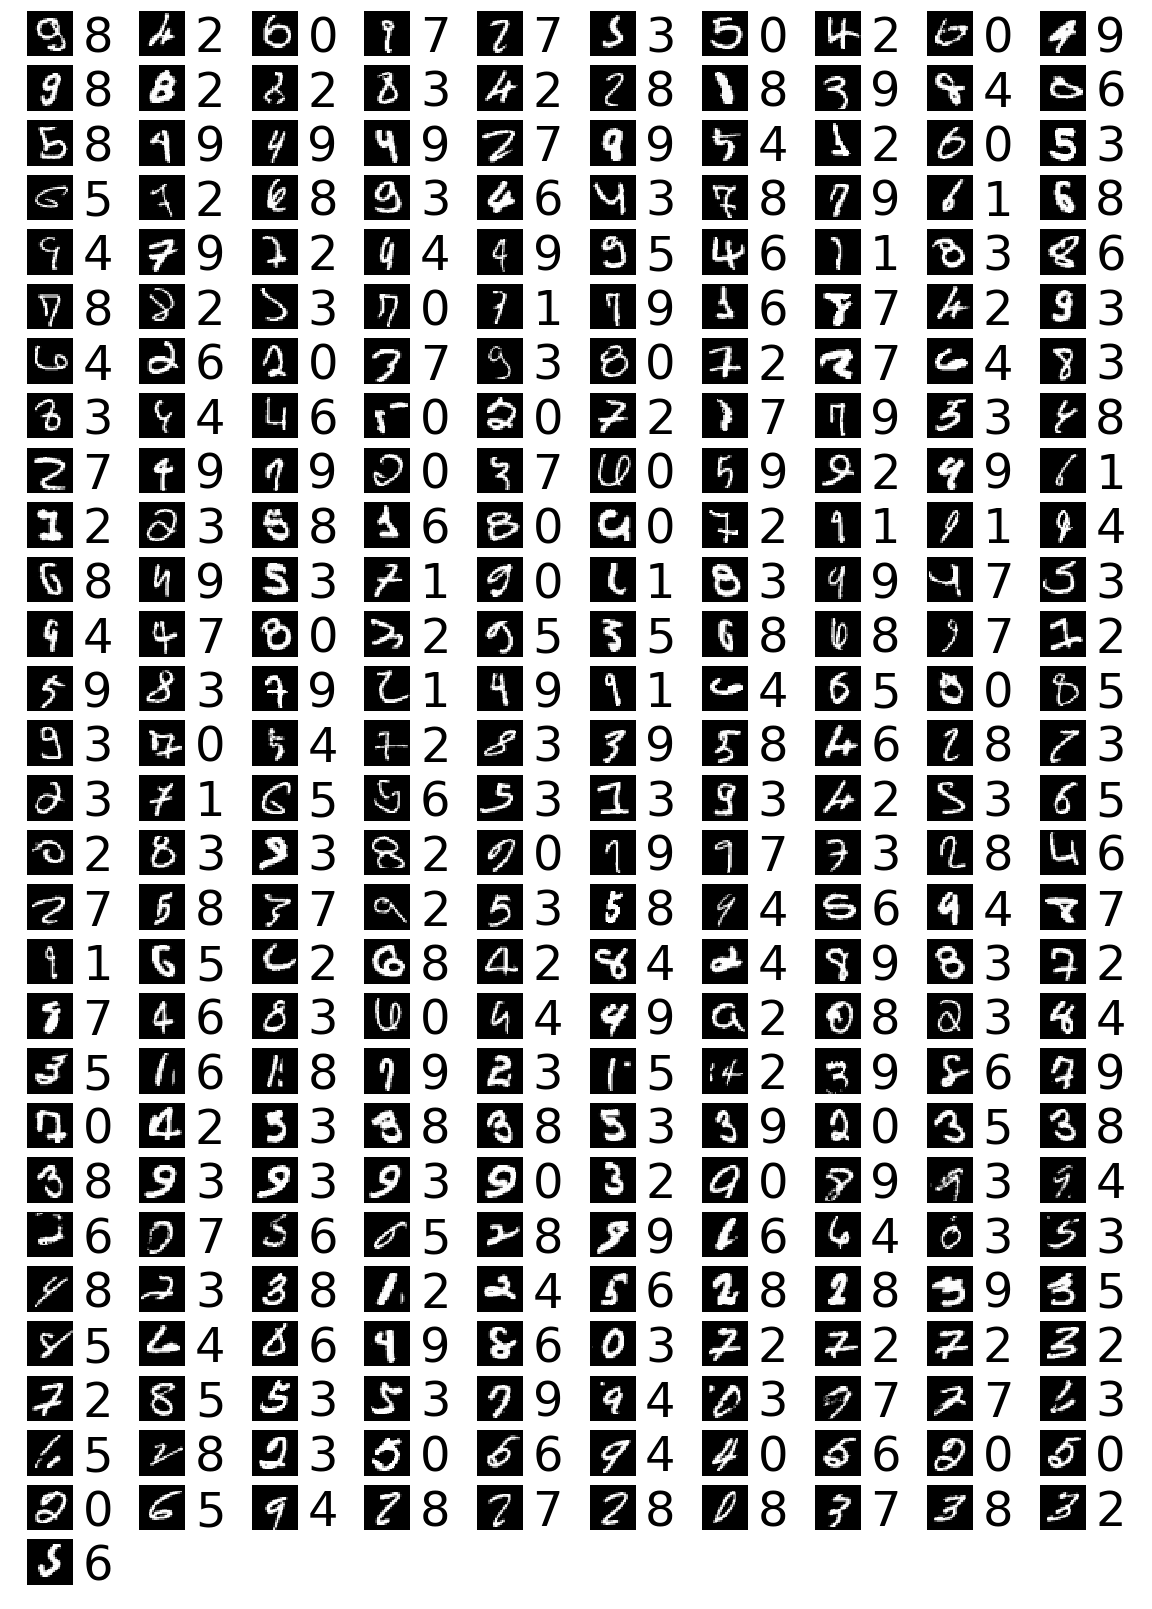

In [496]:
prediction = np.argmax(result6, axis=1)
indices = mnist.test_label.label != prediction
error_images = mnist.test_image.data[indices, :]
pred = prediction[indices]
fig = plt.figure(figsize=(20, 40))
for i in range(error_images.shape[0]):
    fig.add_subplot(40, 20, 2*i + 1).axis("off")
    plt.imshow(error_images[i,:].reshape(28,28), figure=fig)
    fig.add_subplot(40, 20, 2*i + 2).axis("off")
    plt.text(0.0, 0.1, str(pred[i]), fontsize=48)